In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'epochs': 10,
    'save_model': False,
    'evaluate_model': True
}

In [5]:
from sklearn import preprocessing


transformations = {
    "standard": preprocessing.StandardScaler(),
    "min_max": preprocessing.MinMaxScaler()
}

def scale_df(df, method):
    x = df.values
    scaler = transformations[method]
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

tf_z =  scale_df(tf.T, method='standard').T

In [9]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def get_gluon_ds(df):

    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values[:, :-metadata['prediction_length']],
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values,
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])
          
    return train_ds, test_ds

In [6]:
train_ds, test_ds = get_gluon_ds(tf)

In [7]:
import inspect
from pathlib import Path

import inspect
from pathlib import Path

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def get_cls_attributes(cls):
    attributes = inspect.getmembers(cls, lambda x: not(inspect.isroutine(x)))
    attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
    return dict(attributes)


def get_hyperparams(estimator, predictor_id):
    predictor = type(estimator).__name__
    estimator_attr = get_cls_attributes(estimator)
    trainer_attr = get_cls_attributes(estimator_attr['trainer'])
    attributes = {**estimator_attr, **trainer_attr}
    attributes.pop('trainer', None)
    attributes['predictor'] = predictor
    attributes['predictor_id'] = predictor_id
    return dict(attributes)


def to_model_database(attributes):
    fpath = os.path.join(data_dir, 'sensitivity-metrics-test.csv')
    if not os.path.exists(fpath):
        pd.DataFrame([attributes]).to_csv(fpath, header=True, index=False)
        return print(f"Created metrics database: {fpath}")
    params = pd.read_csv(fpath)
    to_add_params = pd.DataFrame([attributes])
    updated_params = pd.concat([params, to_add_params], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)
    return print(f"Updated metrics database: {fpath}")


batch_size = 16
epochs = 10
num_batches_per_epoch = 200
cardinality = [
    len(sites['fcluster'].unique()), 
    len(sites['dbscan_cluster'].unique())
]


def train_eval_loop():

    estimator = SimpleFeedForwardEstimator(
        num_hidden_dimensions=[10],
        prediction_length=metadata['prediction_length'],
        freq=metadata['freq'],
        trainer=Trainer(ctx="cpu",
                        epochs=epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )

    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)

    predictor = estimator.train(train_ds)

    if metadata['save_model'] is True:
        mpath = os.path.join(model_dir, f"{attributes['predictor']}-{predictor_id}")
        if not os.path.exists(mpath):
            os.mkdir(mpath)
        predictor.serialize(Path(mpath))

    if metadata['evaluate_model'] is True:
        forecast_it, ts_it = make_evaluation_predictions(
            test_ds, predictor=predictor, num_samples=100
        )
        agg_metrics, item_metrics = Evaluator()(
            ts_it, forecast_it, num_series=len(test_ds)
        )
        attributes = {**attributes, **agg_metrics}
    
    to_model_database(attributes)
    return agg_metrics

    


In [10]:
results = []
for ds in [tf, tf_z]:
    for prediction_length in np.arange(7, 8):
        metadata['prediction_length'] = prediction_length
        train_ds, test_ds = get_gluon_ds(ds)
        test_ds = ListDataset(test_ds.list_data[:200], freq=metadata['freq'])
        results.append(train_eval_loop())

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 200/200 [00:00<00:00, 271.59it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics-test.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 200/200 [00:00<00:00, 308.18it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics-test.csv


In [11]:
results[0]

{'MSE': 1012.8690394864764,
 'abs_error': 38598.171630859375,
 'abs_target_sum': 1112432.0180664062,
 'abs_target_mean': 794.5942986188617,
 'seasonal_error': 12.928196844482422,
 'MASE': 2.468945538458807,
 'MAPE': 0.03516172117621618,
 'sMAPE': 0.035963334871888054,
 'OWA': nan,
 'MSIS': 12.89620388593917,
 'QuantileLoss[0.1]': 15104.411477661133,
 'Coverage[0.1]': 0.009285714285714284,
 'QuantileLoss[0.2]': 24017.844836425786,
 'Coverage[0.2]': 0.019999999999999997,
 'QuantileLoss[0.3]': 30691.679595947266,
 'Coverage[0.3]': 0.03,
 'QuantileLoss[0.4]': 35526.43216552735,
 'Coverage[0.4]': 0.04928571428571429,
 'QuantileLoss[0.5]': 38598.171630859375,
 'Coverage[0.5]': 0.07428571428571427,
 'QuantileLoss[0.6]': 40153.46754150391,
 'Coverage[0.6]': 0.115,
 'QuantileLoss[0.7]': 38603.3835144043,
 'Coverage[0.7]': 0.17,
 'QuantileLoss[0.8]': 33121.62924804688,
 'Coverage[0.8]': 0.2592857142857143,
 'QuantileLoss[0.9]': 20142.18853149414,
 'Coverage[0.9]': 0.4871428571428571,
 'RMSE': 31

In [12]:
results[1]

{'MSE': 2.283221430118595,
 'abs_error': 1886.1351835727692,
 'abs_target_sum': 1691.5154285430908,
 'abs_target_mean': 1.208225306102208,
 'seasonal_error': 0.6620087969303131,
 'MASE': 2.501154663743134,
 'MAPE': 1.798638601791059,
 'sMAPE': 1.7427146093672758,
 'OWA': nan,
 'MSIS': 24.451855083558495,
 'QuantileLoss[0.1]': 681.1119014263154,
 'Coverage[0.1]': 0.003571428571428571,
 'QuantileLoss[0.2]': 1102.716025778651,
 'Coverage[0.2]': 0.014999999999999998,
 'QuantileLoss[0.3]': 1440.4588181093334,
 'Coverage[0.3]': 0.033571428571428565,
 'QuantileLoss[0.4]': 1702.0661122731865,
 'Coverage[0.4]': 0.06142857142857142,
 'QuantileLoss[0.5]': 1886.1351882200688,
 'Coverage[0.5]': 0.08428571428571428,
 'QuantileLoss[0.6]': 2005.024469898641,
 'Coverage[0.6]': 0.11,
 'QuantileLoss[0.7]': 1998.613268276304,
 'Coverage[0.7]': 0.1492857142857143,
 'QuantileLoss[0.8]': 1815.9791751988232,
 'Coverage[0.8]': 0.2264285714285714,
 'QuantileLoss[0.9]': 1367.0805373847484,
 'Coverage[0.9]': 0.39

In [10]:
for prediction_length in np.arange(1, 12):
    metadata['prediction_length'] = prediction_length
    train_ds, test_ds = get_gluon_ds()
#     test_ds = ListDataset(test_ds.list_data[:200], freq=metadata['freq'])
    train_eval_loop()

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:53<00:00, 697.53it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:46<00:00, 794.64it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:45<00:00, 808.90it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:46<00:00, 793.22it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/100 [00:00<?, ?it/s]

Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:53<00:00, 692.18it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 37111/37111 [00:49<00:00, 750.83it/s]


Updated metrics database: /media/storage/data/shorelines/sensitivity-metrics.csv


In [11]:
fpath = os.path.join(data_dir, 'sensitivity-metrics.csv')
tmp = pd.read_csv(fpath)

In [16]:
tmp['predictor'].unique()

array(['DeepStateEstimator', 'RForecastPredictor',
       'SimpleFeedForwardEstimator'], dtype=object)

In [24]:
tmp.loc[tmp['predictor']=='RForecastPredictor']['MAPE']

11    0.023372
23    0.022942
24    0.025083
25    0.025625
26    0.026110
27    0.025904
28    0.031641
29    0.032107
30    0.036036
31    0.035851
32    0.040002
33    0.042183
34    0.043675
35    0.042870
36    0.048157
Name: MAPE, dtype: float64

In [67]:
def forecast_transects(transects, dataset, predictor, freq=None, 
                       prediction_length=None, **kwargs):
    
    if prediction_length is None:
        prediction_length = metadata['prediction_length']
        
    if freq is None:
        freq = metadata['freq']

    dataset = ListDataset(
        [
            i for i in iter(dataset) if i['item_id'] in transects
        ], 
        freq=metadata['freq']
    )
    return iter(dataset), predictor.predict(dataset)
     
    
duck = [f'BOX_160_055_3{i}' for i in np.arange(42, 50, 1)]    

ffn_ts_it, ffn_forecast_it = forecast_transects(
    transects=duck,
    dataset=test_ds,
    predictor=predictor,
)

### Load model

In [70]:
from gluonts.model.predictor import Predictor
mpath = os.path.join(model_dir, 'SimpleFeedForwardEstimator-176')
predictor_deserialized = Predictor.deserialize(Path(mpath))

### Plot predictions

In [31]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl

plt.style.use(os.path.join(configuration_dir, 'PaperSingleFig.mplstyle'))

def plot_prob_forecast(ax, ts_entry, fcst_entry):
    
    prediction_intervals = (50.0, 90.0)
    legend = [f"{ts_entry['item_id']}", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    
    ts_idx = pd.date_range(
        start=ts_entry["start"],
        periods=len(ts_entry["target"]),
        freq="AS"
    )
    
    ts = pd.Series(ts_entry["target"], index=ts_idx)
    ts.plot(ax=ax)  # plot the time series
    
    fcst_entry.plot(
        prediction_intervals=prediction_intervals,
        color='g'
    ) 
    
    ax.set_ylabel('Relative shoreline position (m)')
    ax.set_xlabel('Time (yrs)')
    ax.grid(which="both")
    ax.legend(legend, loc="upper left")
    
    return ax


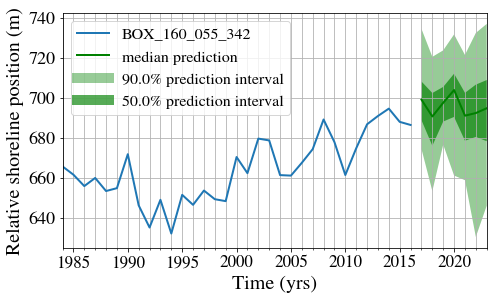

In [68]:
fig, ax = plt.subplots()
plot_prob_forecast(ax, next(ffn_ts_it), next(ffn_forecast_it))
# plt.savefig(os.path.join(report_dir, 'images/ffn.pdf'), dpi=300)
plt.show()